In [1]:
import os
os.chdir('/content/drive/MyDrive/DLProject/Nghia')

In [2]:
from tensorflow.keras.backend import image_data_format
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

In [3]:
x_train = np.load('x_train_resize.npy')
# x_train = np.load('x_train.npy')
y_train = np.load('y_train.npy')
x_test = np.load('x_test_resize.npy')
# x_test = np.load('x_test.npy')
y_test = np.load('y_test.npy')
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(3300, 224, 224, 3)
(3300,)
(2200, 224, 224, 3)
(2200,)


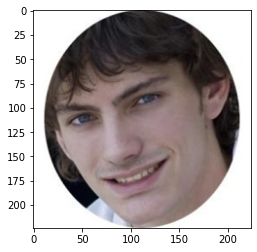

3.516667


In [4]:
plt.imshow(x_train[0])
plt.show()
print(y_train[0])

In [4]:
#The images are converted from RGB to BGR, then each color channel is zero-centered with respect to the ImageNet dataset, without scaling.
x_train_pre = preprocess_input(x_train) 
x_test_pre = preprocess_input(x_test)
# Preprocess_input

In [5]:
# res_model = ResNet50(weights='imagenet',
#                       include_top=True,
#                       input_shape=(224,224,3))
# res_model.summary()

102973440/102967424 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
________________________

In [7]:
base_model = ResNet50(weights='imagenet',
                      include_top=False,
                      input_shape=(224,224,3))
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [14]:
base_model.layers[155].name

'conv5_block1_out'

In [16]:
for layer in base_model.layers:
  layer.trainable = False
# base_model.summary()
for layer in base_model.layers[155:]:
  layer.trainable = True
base_model.summary()


Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [17]:
# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# # # let's add a fully-connected layer
# x = Dense(1024, activation='relu')(x)
# # # let's add another fully-connected layer
# x = Dense(512, activation='relu')(x)
# and a regression layer
predictions = Dense(1)(x)
# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)


In [18]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.metrics import MeanSquaredError, RootMeanSquaredError
model.compile(optimizer=RMSprop(momentum=0.9),
              loss='mse',
              metrics=[RootMeanSquaredError()])
history = model.fit(x_train_pre, y_train, batch_size=16, epochs=20, validation_data=(x_test_pre,y_test))
# validation_split=0.3, epoches = 10
# then train on some last convol layers

Epoch 1/20
207/207 [==============================] - 25s 120ms/step - loss: 1.1155 - root_mean_squared_error: 1.0562 - val_loss: 0.5758 - val_root_mean_squared_error: 0.7588
Epoch 2/20
207/207 [==============================] - 21s 103ms/step - loss: 0.2026 - root_mean_squared_error: 0.4502 - val_loss: 0.3236 - val_root_mean_squared_error: 0.5689
Epoch 3/20
207/207 [==============================] - 21s 101ms/step - loss: 0.1606 - root_mean_squared_error: 0.4008 - val_loss: 0.1944 - val_root_mean_squared_error: 0.4409
Epoch 4/20
207/207 [==============================] - 21s 102ms/step - loss: 0.1285 - root_mean_squared_error: 0.3585 - val_loss: 0.1806 - val_root_mean_squared_error: 0.4250
Epoch 5/20
207/207 [==============================] - 21s 103ms/step - loss: 0.1168 - root_mean_squared_error: 0.3417 - val_loss: 0.1818 - val_root_mean_squared_error: 0.4264
Epoch 6/20
207/207 [==============================] - 21s 103ms/step - loss: 0.0889 - root_mean_squared_error: 0.2982 - val_l

In [19]:
model.evaluate(x_test_pre, y_test)

69/69 [==============================] - 7s 108ms/step - loss: 0.1781 - root_mean_squared_error: 0.4221


[0.17812740802764893, 0.42205142974853516]

In [20]:
history.history.keys()

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])

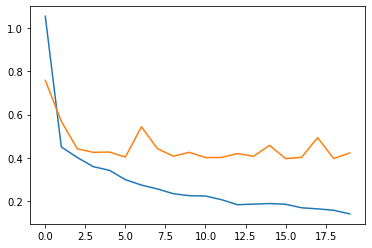

In [21]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.show()

2.8 [[2.646321]]


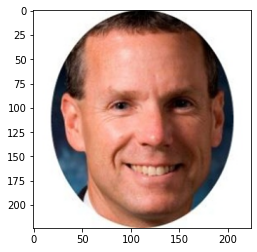

In [14]:
test_img = x_test_pre[[0]]
# test_img = test_img[np.newaxis, :, :, :]
print(y_test[0], model.predict(test_img))
plt.imshow(x_test[0])

In [ ]:
ids = np.where(y_test>=0.95*np.max(y_test))
y_pred = model.predict(x_test_pre)

In [ ]:
x_test[305].shape

In [ ]:

for id in ids[0]:
  best_img = x_test[id]
  best_img = best_img[np.newaxis, :, :, :]
  print(y_test[id], y_pred[id])
  plt.subplot()
  plt.imshow(best_img[0])
  plt.show()

In [ ]:
best_img.shape

In [ ]:
id